In [1]:
import numpy as np
import pandas as pd
import math
import sklearn
import os
import gc
import random
import re
import csv

from typing import List, Dict, Tuple
import torch
from holoviews.operation import threshold
from numba.scripts.generate_lower_listing import description

from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import dataset, TensorDataset, DataLoader, RandomSampler, SequentialSampler, Dataset
from itertools import *
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split

from captum.concept import TCAV
from captum.concept import Concept
from captum.concept._utils.common import concepts_to_str
import matplotlib.pyplot as plt
import seaborn as sns
from captum.attr._core.layer.layer_activation import LayerActivation 

from sklearn.svm import SVC
from sucideClassifier import TextClassificationModel

import pickle


C:\Users\salma\anaconda3\envs\env-gpu-10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Initialising parameters

In [2]:
files_dir = "../Suicide_files"
SENSITIVITY_DIR = os.path.join(files_dir, "sensitivity")
GRADIENTS_DIR = os.path.join(files_dir, "gradients")
CAVS_DIR = os.path.join(files_dir, "CAVs")
TCAVQ_DIR = os.path.join(files_dir, "tcavscores")
CLASSES_LIST = ["pos", "neg"]

In [44]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Loading Data

In [5]:
neg_df = pd.read_csv(os.path.join(files_dir,"clustering_results/neg_concepts_400.csv"))
neg_df.head(2)


,0,1,2,3,4,5,6,7,8,9,...,761,762,763,764,765,766,767,token,sentence,cluster
0,0.360323,0.114374,0.676890,0.103780,0.757371,-0.525596,0.420956,-0.142302,-0.266890,0.136968,...,0.215903,0.280968,-0.049321,-0.433429,-0.739617,0.966563,0.672262,normal,normal ##ise watching dubbed anime i don ’ t ...,369
1,0.602526,0.503210,0.866292,0.579463,-0.461009,-0.364513,-0.504592,1.094945,-0.874246,0.266348,...,0.618638,0.640342,-0.171106,0.378658,0.536331,0.711122,-0.144049,watching,normal ##ise watching dubbed anime i don ’ t ...,5


In [6]:
pos_df = pd.read_csv(os.path.join(files_dir,"clustering_results/pos_concepts.csv"))
pos_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,761,762,763,764,765,766,767,token,sentence,cluster
0,0.092361,0.537579,-0.108185,-0.369392,0.656724,1.118478,-0.146349,-0.118915,0.962345,-1.016192,...,0.525619,-0.005307,-0.348388,0.378788,0.571991,0.303386,0.014218,every,every little problem makes me want to kill my...,338
1,0.023838,0.095783,-0.089390,-0.010807,0.186203,0.555168,0.653269,-0.773034,-0.557048,-0.434466,...,-0.067425,-0.322750,-0.682568,-0.405120,-0.133127,0.074864,-0.234065,little,every little problem makes me want to kill my...,184


## Concept Functions

In [7]:
def concept_dataset_from_file(concept_file):
    df = pd.read_csv(concept_file, index_col=0).drop(['token', 'cluster'], axis=1)
    X = np.array(df)
    return X

def concept_dataset_from_df(concept_df, selector):
    concept_samples = concept_df[concept_df[list(selector.keys())[0]]== list(selector.values())[0]]
    X=np.array(concept_samples.drop(['token','sentence', 'cluster'], axis=1))
    return X, list(concept_samples['token']), list(concept_samples['sentence'])


def random_concept_dataset_from_df_multi(target_df, other_df, concept_id, size,random_state = 42):
    target_samples = target_df.copy()
    target_samples = target_samples[target_samples['cluster']!=concept_id]
    target_samples['class'] = "target"
    other_samples = other_df.copy()
    other_samples['class'] = "other"
    all_samples_df = pd.concat([target_samples, other_samples])
    ratio = size/all_samples_df.shape[0]
    random_samples = all_samples_df.groupby('class', group_keys=False).apply(lambda x: x.sample(frac = ratio, random_state=random_state))

    X=np.array(random_samples.drop(['token', 'sentence','cluster', 'class'], axis=1))
    return X, list(random_samples['token']), list(random_samples['sentence'])

def create_cav(ds1, ds2):
    dataset1 = ds1[:min(len(ds1), len(ds2))]
    dataset2 = ds2[:min(len(ds1), len(ds2))]
    X = np.concatenate((dataset1,dataset2))
    y = np.concatenate((np.ones(dataset1.shape[0]), np.zeros(dataset2.shape[0])))
    clf =  SVC(kernel='linear',gamma='auto')
    clf.fit(X, y)
    return clf.score(X, y), clf.coef_




In [7]:
r1, r2, r3= random_concept_dataset_from_df_multi(pos_df, neg_df, 338, 400)
print(r1.shape)
print(len(r2))
print(len(r3))

(400, 768)
400
400


## Computing gradients

In [7]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
# device="cpu"

model = TextClassificationModel(768, 2)
model.load_state_dict(torch.load(os.path.join(files_dir,f"models/bert_suicide_BCELoss_27June.pt")))
model.to(device)


embedding dimension 768


TextClassificationModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

### Fetching evaluation data

In [8]:
data = pd.read_csv(os.path.join(files_dir, "suicide/Suicide_Detection.csv"), index_col=0)
data.head(2)

,text,class
2,Ex Wife Threatening SuicideRecently I left my ...,suicide
3,Am I weird I don't get affected by compliments...,non-suicide


In [9]:
data['label'] = (data['class']=='suicide').astype('Int64')
X= np.array(data['text'])
y = np.array(data['label'])
X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.2, shuffle=True, stratify= y, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((185659,), (185659,), (46415,), (46415,))

In [10]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', truncation=True, max_length=512)
def bert_tokenizer(text: str) -> Tuple[Tensor, Tensor]:
    tokens = tokenizer.__call__(text, return_tensors='pt', padding='max_length', max_length=512, truncation=True)
    words = tokenizer.convert_ids_to_tokens(tokens['input_ids'][0])

    return tokens['input_ids'], tokens['attention_mask'], words
def encode_labels(labels) -> Tensor:
    return F.one_hot(torch.tensor([y for y in labels])).to(torch.float32)

In [11]:
X_train_neg = X_train[np.invert(y_train.astype(bool))]
X_train_pos = X_train[y_train.astype(bool)]

### Computation

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device="cpu"
gradient_start_index=180
gradient_end_index = gradient_start_index+20

def prepare_no_labels(data,start_idx=None, end_idx=None):
    input_ids = []
    attention_masks = []
    for t in data[start_idx:end_idx]:
        tokens = bert_tokenizer(t)
        input_ids.append(tokens[0])
        attention_masks.append(tokens[1])
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    # print(input_ids.shape, attention_masks.shape)
    return (input_ids.to(device), attention_masks.to(device))

neg_ds =prepare_no_labels(X_train_neg, gradient_start_index, gradient_end_index)
pos_ds =prepare_no_labels(X_train_pos, gradient_start_index, gradient_end_index)

In [13]:
from datetime import datetime


In [15]:

for i in range(500, 9000, 20):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # device="cpu"
    gradient_start_index=i
    gradient_end_index = gradient_start_index+20

    def prepare_no_labels(data,start_idx=None, end_idx=None):
        input_ids = []
        attention_masks = []
        for t in data[start_idx:end_idx]:
            tokens = bert_tokenizer(t)
            input_ids.append(tokens[0])
            attention_masks.append(tokens[1])
        input_ids = torch.cat(input_ids, dim=0)
        attention_masks = torch.cat(attention_masks, dim=0)
        # print(input_ids.shape, attention_masks.shape)
        return (input_ids.to(device), attention_masks.to(device))

    neg_ds =prepare_no_labels(X_train_neg, gradient_start_index, gradient_end_index)
    pos_ds =prepare_no_labels(X_train_pos, gradient_start_index, gradient_end_index)
    gc.collect()
    tcav = TCAV(model, layers=['bert.encoder.layer.11'])
    posgrad = tcav.interpret2(pos_ds, target = 1, experimental_sets=[])
    neggrad = tcav.interpret2(neg_ds, target = 0, experimental_sets=[])
    torch.save(posgrad, os.path.join(files_dir,f"new_gradients/posgrad_layer11_{gradient_start_index}_{gradient_end_index}.pt"))
    torch.save(neggrad, os.path.join(files_dir,f"new_gradients/neggrad_layer11_{gradient_start_index}_{gradient_end_index}.pt"))
    print(f"current i: {i}, time: {datetime.now()}")


current i: 500, time: 2025-10-23 12:15:41.829121
current i: 520, time: 2025-10-23 12:15:47.713465
current i: 540, time: 2025-10-23 12:15:53.706411
current i: 560, time: 2025-10-23 12:15:59.804477
current i: 580, time: 2025-10-23 12:16:05.760142
current i: 600, time: 2025-10-23 12:16:11.931828
current i: 620, time: 2025-10-23 12:16:17.970767
current i: 640, time: 2025-10-23 12:16:24.124951
current i: 660, time: 2025-10-23 12:16:30.072815
current i: 680, time: 2025-10-23 12:16:36.018970
current i: 700, time: 2025-10-23 12:16:42.252925
current i: 720, time: 2025-10-23 12:16:48.211456
current i: 740, time: 2025-10-23 12:16:54.259993
current i: 760, time: 2025-10-23 12:17:00.196657
current i: 780, time: 2025-10-23 12:17:06.201228
current i: 800, time: 2025-10-23 12:17:12.513264
current i: 820, time: 2025-10-23 12:17:18.612808
current i: 840, time: 2025-10-23 12:17:24.673856
current i: 860, time: 2025-10-23 12:17:30.619178
current i: 880, time: 2025-10-23 12:17:36.531881
current i: 900, time

KeyboardInterrupt: 

In [27]:
# del data
# del X_train_neg
# del X_train_pos
# del X_train
# del y_train
# del X_test
# del y_test
gc.collect()

96

In [ ]:
# tcav = TCAV(model, layers=['bert.encoder.layer.11'])

d:\salma\_MSc\Lab\ConceptExplanations\captum\concept\_utils\classifier.py:130: UserWarning: Using default classifier for TCAV which keeps input both train and test datasets in the memory. Consider defining your own classifier that doesn't rely heavily on memory, for large number of concepts, by extending `Classifer` abstract class
  warnings.warn(


In [ ]:
# posgrad = tcav.interpret2(pos_ds, target = 1, experimental_sets=[])
# neggrad = tcav.interpret2(neg_ds, target = 0, experimental_sets=[])

In [ ]:
# torch.save(posgrad, f"gradients/posgrad_layer11_{gradient_start_index}_{gradient_end_index}.pt")
# torch.save(neggrad, f"gradients/neggrad_layer11_{gradient_start_index}_{gradient_end_index}.pt")

In [ ]:
# gradient_start_index = 10000
# gradient_end_index = gradient_start_index+50
# posgrad=torch.load(f"gradients/posgrad_layer11_{gradient_start_index}_{gradient_end_index}.pt")
# neggrad=torch.load(f"gradients/neggrad_layer11_{gradient_start_index}_{gradient_end_index}.pt")

#### saving gradient vectors

In [29]:
from datetime import datetime


In [71]:

for i in range(20050, 20100, 20):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # device="cpu"
    gradient_start_index=i
    gradient_end_index = gradient_start_index+20

    def prepare_no_labels(data,start_idx=None, end_idx=None):
        input_ids = []
        attention_masks = []
        for t in data[start_idx:end_idx]:
            tokens = bert_tokenizer(t)
            input_ids.append(tokens[0])
            attention_masks.append(tokens[1])
        input_ids = torch.cat(input_ids, dim=0)
        attention_masks = torch.cat(attention_masks, dim=0)
        # print(input_ids.shape, attention_masks.shape)
        return (input_ids.to(device), attention_masks.to(device))

    neg_ds =prepare_no_labels(X_train_neg, gradient_start_index, gradient_end_index)
    pos_ds =prepare_no_labels(X_train_pos, gradient_start_index, gradient_end_index)
    gc.collect()
    tcav = TCAV(model, layers=['bert.encoder.layer.11'])
    posgrad = tcav.interpret2(pos_ds, target = 1, experimental_sets=[])
    neggrad = tcav.interpret2(neg_ds, target = 0, experimental_sets=[])
    torch.save(posgrad, f"gradients/posgrad_layer11_{gradient_start_index}_{gradient_end_index}.pt")
    torch.save(neggrad, f"gradients/neggrad_layer11_{gradient_start_index}_{gradient_end_index}.pt")
    print(f"current i: {i}, time: {datetime.now()}")


d:\salma\_MSc\Lab\ConceptExplanations\captum\concept\_utils\classifier.py:130: UserWarning: Using default classifier for TCAV which keeps input both train and test datasets in the memory. Consider defining your own classifier that doesn't rely heavily on memory, for large number of concepts, by extending `Classifer` abstract class
  warnings.warn(


KeyboardInterrupt: 

## Sensitivity Scores

In [41]:
gradient_files = {}
for c in ["pos", "neg"]:
    gradient_files[c] = [x.rstrip(".pt") for x in os.listdir(os.path.join(GRADIENTS_DIR,c))]
gradient_files


{'pos': ['posgrad_layer11_0_20',
  'posgrad_layer11_10000_10050',
  'posgrad_layer11_1000_1020',
  'posgrad_layer11_10050_10100',
  'posgrad_layer11_100_120',
  'posgrad_layer11_1020_1040',
  'posgrad_layer11_1040_1060',
  'posgrad_layer11_1060_1080',
  'posgrad_layer11_10700_10750',
  'posgrad_layer11_1080_1100',
  'posgrad_layer11_1100_1120',
  'posgrad_layer11_1120_1140',
  'posgrad_layer11_1140_1160',
  'posgrad_layer11_1160_1180',
  'posgrad_layer11_1180_1200',
  'posgrad_layer11_1200_1220',
  'posgrad_layer11_120_140',
  'posgrad_layer11_1220_1240',
  'posgrad_layer11_1240_1260',
  'posgrad_layer11_1260_1280',
  'posgrad_layer11_1280_1300',
  'posgrad_layer11_1300_1320',
  'posgrad_layer11_1320_1340',
  'posgrad_layer11_1340_1360',
  'posgrad_layer11_1360_1380',
  'posgrad_layer11_1380_1400',
  'posgrad_layer11_1400_1420',
  'posgrad_layer11_140_160',
  'posgrad_layer11_1420_1440',
  'posgrad_layer11_1440_1460',
  'posgrad_layer11_1460_1480',
  'posgrad_layer11_1480_1500',
  'pos

The nothing concept

In [8]:
def save_tcavscores_csv(tcav_row, header_names, file_path):
    if os.path.isfile(file_path):
        with open(file_path, 'a', newline='') as f:
                writer = csv.writer(f)
                writer.writerow(tcav_row)
    else:
        with open(file_path, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(header_names)
            writer.writerow(tcav_row)

def save_sensitivity_csv(sensitivity_row,file_path):
    with open(file_path, 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(sensitivity_row)

def save_cav_csv(tcav_row,file_path):
    with open(file_path, 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(tcav_row)

In [ ]:


def calculate_all_cavs(
    target_class: str,
    classes: List[str],
    df: pd.DataFrame,
    other_df: pd.DataFrame,
    concepts_excluded: List[int],
    random_state: int,
    cav_path: str,
 ):


    for clus in list(set(df['cluster'].unique())-set(concepts_excluded)):
        try:
            # create datasets
            target_dataset, target_tokens, target_sentences = concept_dataset_from_df(df, {'cluster':clus})
            print(clus , target_dataset.shape)
            if (target_dataset.shape[0])>10:
                neutral_dataset , neutral_tokens, neutral_sentences= random_concept_dataset_from_df_multi(df, other_df, clus, 2*len(target_dataset),random_state=random_state)

                # create CAV from target_dataset vs neutral_dataset
                _, cav =create_cav(target_dataset, neutral_dataset)

                save_cav_csv(np.concatenate(([clus],cav[0])), os.path.join(cav_path,target_class,f"all_cav_rand_{random_state}.csv"))

        except FileNotFoundError as e:
            print(f"Warning: concept {clus} failed with error : {e}")
            continue




def avg_all_gradients(target_class, gradient_cols: List[str], avg_gradient_path):
    gradients = np.array([[0]*768])
    total_samples = 0
    for grad_col in gradient_cols[target_class]:
        clas, layer, start, end = grad_col.split("_")[:]
        num_samples = int(end)-int(start)
        total_samples += num_samples

        gradient_vector = torch.load(os.path.join(GRADIENTS_DIR,str(target_class),f"{target_class}grad_{layer}_{start}_{end}.pt")).cpu()
        gradient_vector = gradient_vector.reshape(-1,768)
        gradient_vector = np.array(np.split(gradient_vector,num_samples, axis=0))

        gradient_vector = np.average(gradient_vector, axis=1)

        gradients = np.concatenate((gradients, gradient_vector), axis = 0)

    gradients = gradients[1:]
    return gradients


def calculate_all_sensitivities_faster(
    all_concept_activation_vectors: np.ndarray,
    all_gradients: np.ndarray,
    sensitivity_out_file: str
):
    sensitivity_matrix = np.matmul(all_gradients, all_concept_activation_vectors.T)
    with open(sensitivity_out_file, 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerows(sensitivity_matrix)



In [ ]:
data_class = "neg"
concept_class = "pos"
avg_grads = avg_all_gradients(data_class, gradient_files, "")
grad_df = pd.DataFrame(avg_grads)
print(grad_df.shape)
grad_df.to_csv(os.path.join(GRADIENTS_DIR, f"{data_class}_all_avg_gradients.csv"), index=False)
#load cavs
all_cavs_df = pd.read_csv(os.path.join(CAVS_DIR,concept_class ,"cav_rand_42.csv"), header=None)
all_cavs = np.array(all_cavs_df.drop(0, axis=1).values)
del all_cavs_df

# load avg grads
all_grads_df = pd.read_csv(os.path.join(GRADIENTS_DIR, f"{data_class}_all_avg_gradients.csv"))

all_grads = np.array(all_grads_df.values)
del all_grads_df
print(f"grads shape: {all_grads.shape}  cavs shape: {all_cavs.shape}")
# calculate_all_sensitivities_faster()

calculate_all_sensitivities_faster( all_concept_activation_vectors = all_cavs,
                                        all_gradients = all_grads,
    sensitivity_out_file = os.path.join(SENSITIVITY_DIR, data_class, f"sensitivity_scores_{data_class}_data_{concept_class}_concepts_faster.csv")
)

In [ ]:
sens_faster_df = pd.read_csv(os.path.join(SENSITIVITY_DIR, data_class, f"sensitivity_scores_{data_class}_data_{concept_class}_concepts_faster.csv"), header=None)
sens_faster_df.shape

## Reading and analysing sensitivity scores

In [106]:
sensitivity_scores_df = pd.read_csv(os.path.join(SENSITIVITY_DIR,"pos","sensitivity_scores_pos_data_neg_concepts.csv"), header=None)
sensitivity_scores_df.set_index(0, inplace=True)
sensitivity_scores_df.head()

,1,2,3,4,5,6,7,8,9,10,...,10171,10172,10173,10174,10175,10176,10177,10178,10179,10180
0,,,,,,,,,,,,,,,,,,,,,
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000008,-1.804332e-07,...,0.0,0.0,0.0,0.0,0.0,-1.118670e-07,0.0,0.0,0.0,0.0
1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000021,-4.528718e-07,...,0.0,0.0,0.0,0.0,0.0,-2.813372e-07,0.0,0.0,0.0,0.0
2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000011,-2.481331e-07,...,0.0,0.0,0.0,0.0,0.0,-1.539571e-07,0.0,0.0,0.0,0.0
3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000025,-4.653203e-07,...,0.0,0.0,0.0,0.0,0.0,-2.860258e-07,0.0,0.0,0.0,0.0
4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000046,-8.288414e-07,...,0.0,0.0,0.0,0.0,0.0,-5.058516e-07,0.0,0.0,0.0,0.0


In [119]:
lower_bound = min([x for x in np.array(sensitivity_scores_df).flatten() if x>0]) #positive lower bound
upper_bound = max(np.array(sensitivity_scores_df).flatten())
print(f"Lower bound : {lower_bound}")
print(f"Upper bound : {upper_bound}")

Lower bound : 2.7097040321184417e-15
Upper bound : 0.0008639959171481


### Calculcate log TCAVQ

In [120]:
def binArray(input_data, bins):
    input_data = np.array(input_data).copy()
    input_data = np.array([max(x, 0) for x in input_data])
    bin_dict = {}
    for i in range(0, len(bins)-1):
        bin_dict[bins[i]] = len(input_data[(input_data >= bins[i]) & (input_data < bins[i+1])])
    bin_dict[bins[-1]] = len(input_data[input_data >= bins[-1]])
    return bin_dict
binrange = np.logspace(-20, 0, num=42)
binned_sensitivity = binArray(sensitivity_scores_df.loc[131], binrange)
print(binned_sensitivity)
print(sum(binned_sensitivity.values()))

{1e-20: 0, 3.074715081321838e-20: 0, 9.45387283130796e-20: 0, 2.906796537132137e-19: 0, 8.937571151054276e-19: 0, 2.748048480853334e-18: 0, 8.449466108283313e-18: 0, 2.5979700872256446e-17: 0, 7.988017808015701e-17: 0, 2.456087882417329e-16: 0, 7.551770453120379e-16: 0, 2.321954250288979e-15: 0, 7.139347751502866e-15: 0, 2.195146020234702e-14: 0, 6.749448574119223e-14: 0, 2.0752631321450554e-13: 55, 6.380842850117596e-13: 998, 1.96192737428012e-12: 724, 6.032367686157239e-12: 1213, 1.854781190070611e-11: 872, 5.7029236976621745e-11: 671, 1.7534865500829592e-10: 674, 5.391471540435054e-10: 758, 1.6577238855893143e-09: 763, 5.097028631688902e-09: 836, 1.5671910803783082e-08: 699, 4.8186660501522495e-08: 579, 1.4816025176256596e-07: 434, 4.55550560546802e-07: 309, 1.4006881788178695e-06: 207, 4.306717067640505e-06: 264, 1.3241927918860426e-05: 114, 4.071515547789685e-05: 7, 0.00012518750258625294: 0, 0.0003849159021949685: 0, 0.0011835067295194713: 0, 0.003638945990099404: 0, 0.0111887221

In [121]:
def log_tcav(binned_data):
    return sum([np.log(1+x) for x in binned_data.values() if x>0])
log_tcav(binned_sensitivity)

106.88492266302711

log tcav  106.88492266302711


C:\Users\salma\AppData\Local\Temp\ipykernel_26004\587883296.py:8: RuntimeWarning: divide by zero encountered in log
  plt.plot(binned_sensitivity.keys(), np.log(list(binned_sensitivity.values())))


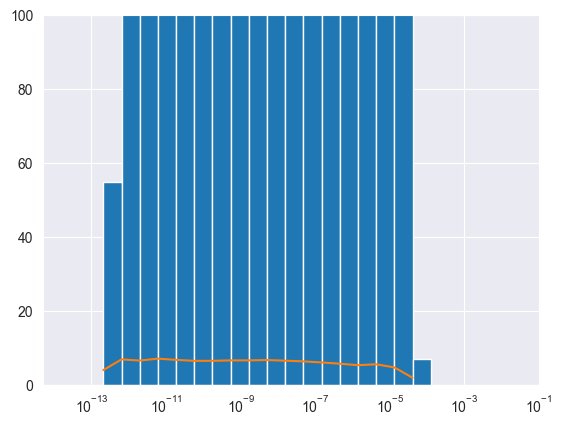

In [123]:
idx = 131
binned_sensitivity = binArray(sensitivity_scores_df.loc[idx], binrange)
plt.hist(sensitivity_scores_df.loc[idx], bins=binrange);
plt.xlim(0.000000000000005, 10**(-1))
plt.ylim(0, 100)
plt.xscale("log")
print(f"log tcav " , log_tcav(binned_sensitivity))
plt.plot(binned_sensitivity.keys(), np.log(list(binned_sensitivity.values())))
plt.xscale("log")

In [132]:
log_tcavs = sensitivity_scores_df.apply(lambda x : log_tcav(binArray(x, binrange)), axis=1)
log_tcavs

0
0.0       4.653960
1.0       4.653960
2.0       4.653960
3.0       4.653960
4.0       4.653960
           ...    
584.0    46.664719
585.0    36.992850
586.0     4.653960
588.0     4.653960
597.0     4.653960
Length: 299, dtype: float64

In [126]:
tcavq_df = pd.read_csv(os.path.join(TCAVQ_DIR, "pos/tcavscores_multi.csv"))
tcavq_df.set_index('Concept', inplace=True)
tcavq_df.head()

,random_state,pos_tcavq,neg_tcavq,samples,pos_sens_sum,neg_sens_sum,pos_log_tcav,neg_log_tcav
Concept,,,,,,,,
0,42,10177,104,10180,3.686341e-07,-0.000001,103.989442,4.644391
1,42,10177,104,10180,9.904991e-05,0.000095,105.710521,4.644391
2,42,10177,104,10180,1.968640e-04,0.000195,104.309334,4.644391
3,42,10177,104,10180,2.959310e-04,0.000291,104.331121,4.644391
4,42,10177,104,10180,3.955080e-04,0.000386,103.460224,4.644391


In [134]:
tcavq_df['neg_log_tcav'] = log_tcavs
tcavq_df.head()

,random_state,pos_tcavq,neg_tcavq,samples,pos_sens_sum,neg_sens_sum,pos_log_tcav,neg_log_tcav
Concept,,,,,,,,
0,42,10177,104,10180,3.686341e-07,-0.000001,104.049580,4.65396
1,42,10177,104,10180,9.904991e-05,0.000095,106.015516,4.65396
2,42,10177,104,10180,1.968640e-04,0.000195,104.361342,4.65396
3,42,10177,104,10180,2.959310e-04,0.000291,104.390233,4.65396
4,42,10177,104,10180,3.955080e-04,0.000386,104.261624,4.65396


In [135]:
sum(tcavq_df['neg_log_tcav'].isna())

0

In [102]:
tcavq_df['neg_log_tcav']

0      48.698893
1            NaN
2      48.674781
3      50.586082
4      48.367403
         ...    
242          NaN
243          NaN
244          NaN
245          NaN
246          NaN
Name: neg_log_tcav, Length: 247, dtype: float64

In [137]:
tcavq_df.reset_index(inplace=True)
tcavq_df.head()

,Concept,random_state,pos_tcavq,neg_tcavq,samples,pos_sens_sum,neg_sens_sum,pos_log_tcav,neg_log_tcav
0,0,42,10177,104,10180,3.686341e-07,-0.000001,104.049580,4.65396
1,1,42,10177,104,10180,9.904991e-05,0.000095,106.015516,4.65396
2,2,42,10177,104,10180,1.968640e-04,0.000195,104.361342,4.65396
3,3,42,10177,104,10180,2.959310e-04,0.000291,104.390233,4.65396
4,4,42,10177,104,10180,3.955080e-04,0.000386,104.261624,4.65396


In [138]:
tcavq_df.to_csv(os.path.join(TCAVQ_DIR, "pos/tcavscores_multi2.csv"), index=False)

log tcav  60.50682286508479


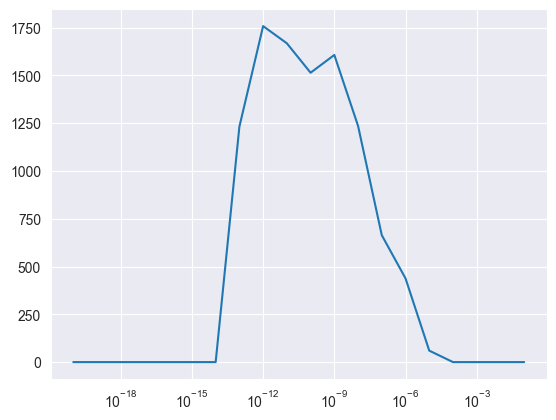

In [109]:
binned_sensitivity = binArray(sensitivity_scores_df.loc[91], binrange)
print(f"log tcav " , log_tcav(binned_sensitivity))
plt.plot(binned_sensitivity.keys(), binned_sensitivity.values())
plt.xscale("log")

In [32]:
np.log(sensitivity_scores_df)
def log_tcav(sens):
    s = sens.copy()
    s = [max(x, 10**(-40)) for x in s]
    s = np.log(s)
    return len(np.where(s>0))
log_tcav(sensitivity_scores_df.iloc[5])
# sensitivity_scores_df['log_TCAVQ'] = sensitivity_scores_df.map()

1

## Estimating Threshold

In [121]:
sensitivity_scores_df1 = pd.read_csv(os.path.join(SENSITIVITY_DIR,"pos","sensitivity_scores_pos_data_pos_concepts_faster.csv"), header=None)
# sensitivity_scores_df.set_index(0, inplace=True)
sensitivity_scores_df2 = pd.read_csv(os.path.join(SENSITIVITY_DIR,"neg","sensitivity_scores_neg_data_pos_concepts_faster.csv"), header=None)
# sensitivity_scores_df.set_index(0, inplace=True)
sensitivity_scores_df1.shape, sensitivity_scores_df2.shape


((10180, 299), (10180, 299))

In [123]:
sensitivity_scores_df2.columns

Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       289, 290, 291, 292, 293, 294, 295, 296, 297, 298],
      dtype='int64', length=299)

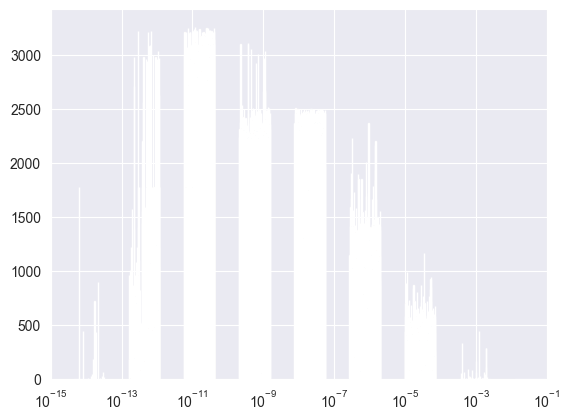

In [117]:

binrange = np.logspace(-15, -1, num=10)
# binned_sensitivity = binArray(sensitivity_scores_df1.values, binrange)
plt.hist(sensitivity_scores_df1.values, bins=binrange);
# plt.hist(sensitivity_scores_df2.values, bins=binrange);

plt.xlim(10**(-15), 10**(-1))
# plt.ylim(0, 100)
plt.xscale("log")
# print(f"log tcav " , log_tcav(binned_sensitivity))
# plt.plot(binned_sensitivity.keys(), np.log(list(binned_sensitivity.values())))
# plt.xscale("log")

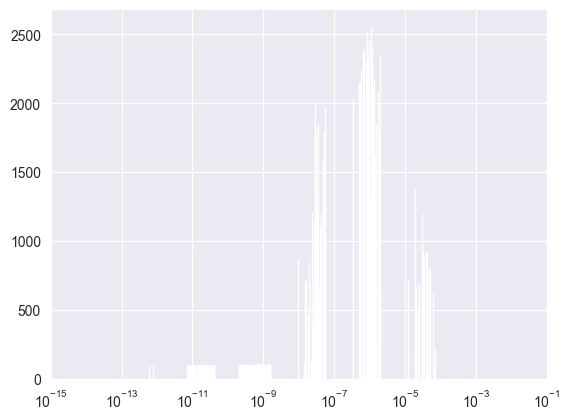

In [122]:

binrange = np.logspace(-15, -1, num=10)
# binned_sensitivity = binArray(sensitivity_scores_df1.values, binrange)
plt.hist(sensitivity_scores_df2.values, bins=binrange);
# plt.hist(sensitivity_scores_df2.values, bins=binrange);

plt.xlim(10**(-15), 10**(-1))
# plt.ylim(0, 100)
plt.xscale("log")
# print(f"log tcav " , log_tcav(binned_sensitivity))
# plt.plot(binned_sensitivity.keys(), np.log(list(binned_sensitivity.values())))
# plt.xscale("log")

setting threshold to 10**-6

In [168]:
#every row is a sample
# every column is a concept
#  IDS come from the CAV Sheet
threshold = 10**-7

thresholded_TCAVQs = [len(np.where(sensitivity_scores_df1[concept_col]>threshold)[0]) for concept_col in sensitivity_scores_df1.columns]

In [162]:
np.std(thresholded_TCAVQs)

297.4044802302404

In [169]:
thresholded_TCAVQs.sort()
thresholded_TCAVQs

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 40,
 72,
 101,
 172,
 174,
 176,
 223,
 280,
 355,
 382,
 416,
 434,
 448,
 518,
 547,
 557,
 563,
 586,
 614,
 616,
 617,
 644,
 664,
 671,
 700,
 704,
 710,
 711,
 797,
 815,
 819,
 826,
 843,
 846,
 867,
 872,
 889,
 890,
 909,
 920,
 923,
 930,
 934,
 935,
 947,
 957,
 964,
 965,
 988,
 990,
 993,
 994,
 999,
 1010,
 1023,
 1024,
 1028,
 1038,
 1041,
 1042,
 1048,
 1049,
 1053,
 1087,
 1118,
 1118,
 1121,
 1125,
 1129,
 1133,
 1138,
 1147,
 1152,
 1155,
 1155,
 1159,
 1162,
 1163,
 1171,
 1182,
 1183,
 1185,
 1188,
 1201,
 1208,
 1215,
 1217,
 1223,
 1228,
 1234,
 1243,
 1263,
 1265,
 1268,
 1271,
 1274,
 1275,
 1275,
 1277,
 1277,
 1282,
 1290,
 1292,
 1292,
 1294,
 1295,
 1299,
 1306,
 1307,
 1308,
 1309,
 1310,
 1312,
 1319,
 1319,
 1325,
 1325,
 1327,
 1328,
 1337,
 1338,
 1342,
 1345,
 1349,
 1356,
 1360,
 1360,
 1360,
 1367,
 1372,
 1382,
 1383,
 1384,
 1385,
 1386,
 1391,
 1393,
 1398,
 1404,
 1404,
 1406,
 1411,
 

In [159]:
max(thresholded_TCAVQs)

3622

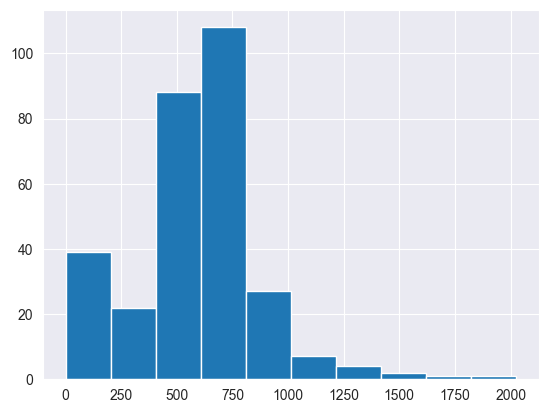

In [163]:
plt.hist(thresholded_TCAVQs);


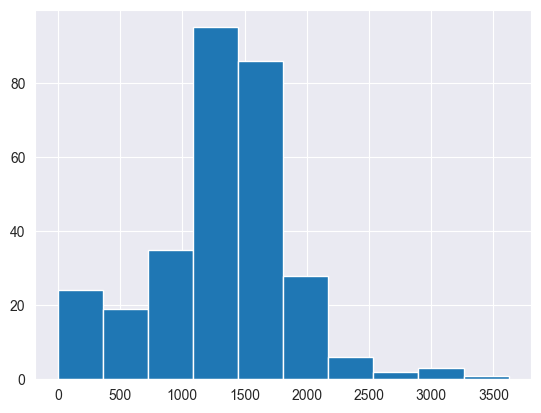

In [160]:
plt.hist(thresholded_TCAVQs);

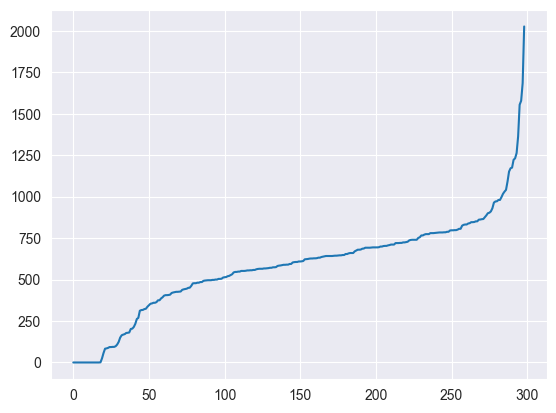

In [167]:
plt.plot(range(0, len(thresholded_TCAVQs)),thresholded_TCAVQs);

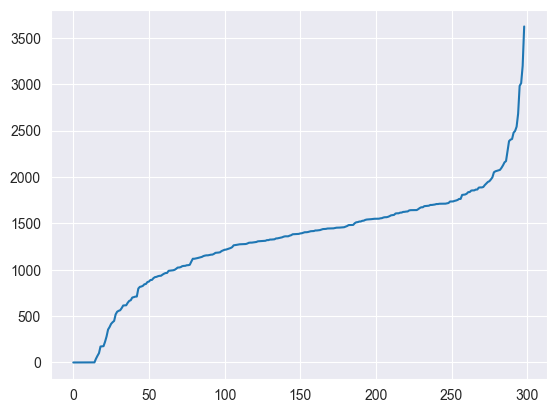

In [170]:
plt.plot(range(0, len(thresholded_TCAVQs)),thresholded_TCAVQs);


In [ ]:
#update tcavs